Customize: Modeling Positions
=============================

Before fitting a strong lens, we can manually specify a set of image-pixels corresponding to the multiple images of the
source-galaxy(s). During the analysis, PyAutoLens will first check that these pixels trace within a specified
arc-second threshold of one another (which is controlled by the `position_threshold` parameter input into a phase). If
they do not meet this threshold, the model is discard and a new sample is generated by the non-linear search.

This provides two benefits:

    1) The analysis runs faster as the `NonLinearSearch` avoids searching regions of parameter space where the
       mass-model is clearly not accurate.

    2) By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is
       because removing the incorrect mass models makes the non-linear parameter space less complex.

In this example script, we fit `Imaging` of a strong lens system where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic`.

The positions are associated with the `Imaging` dataset and they are loaded from a `positions.json` file which is in the
same folder as the dataset itself. To create this file, we used a GUI to `draw on` the positions with our mouse. This
GUI can be found in the script:

 `autolens_workspace/notebooks/preprocess/imaging/gui/positions.py`

If you wish to use positions for modeling your own lens data, you should use this script to draw on the positions of
every lens in you dataset.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset from .fits files, which is the dataset we will use to perform lens modeling. This includes
a `positions.json` file with the positions we use for lens model resampling.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
    positions_path=path.join(dataset_path, "positions.json"),
)

The model-fit also requires a mask, which defines the regions of the image we use to fit the lens model to the data.

We can easily check the image-positions are accurate by plotting them using our `ImagingPlotter`.(they are the 
black dots on the image).

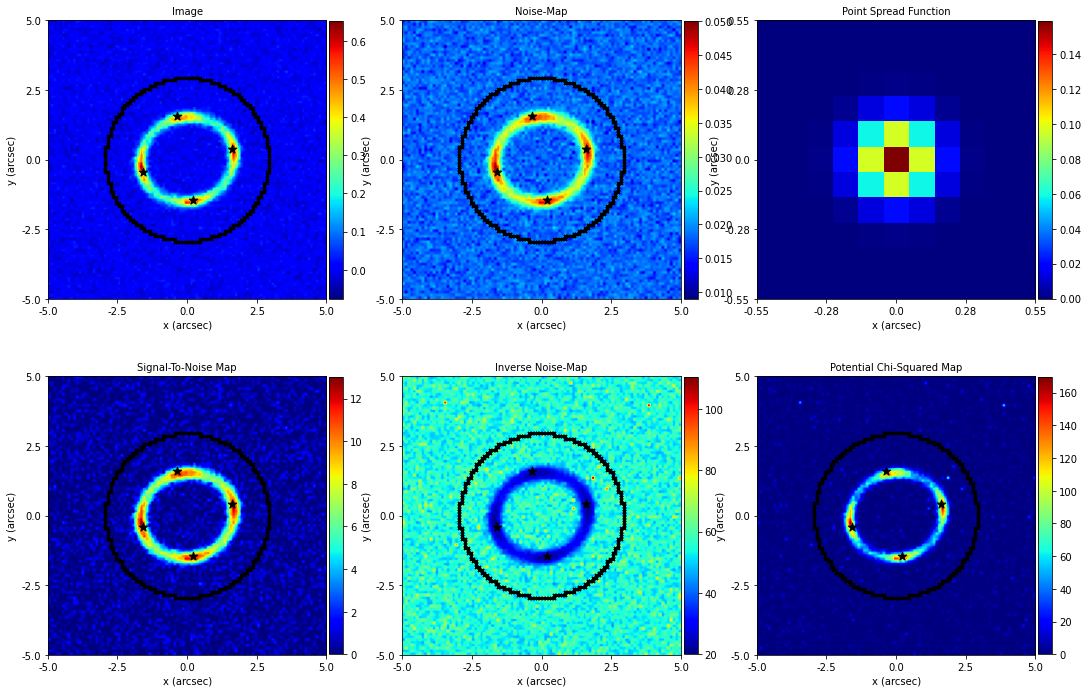

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging.positions)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

Alternatively, the positions can be set up manually in the runner script after loading the data. To do this, we use the 
_Grid2DIrregular_ object, which is used by PyAutoLens to specify lists of (y,x) coordinates that are not on a uniform
or regular grid (which the (y,x) coordinates of a `Grid2D` object are).

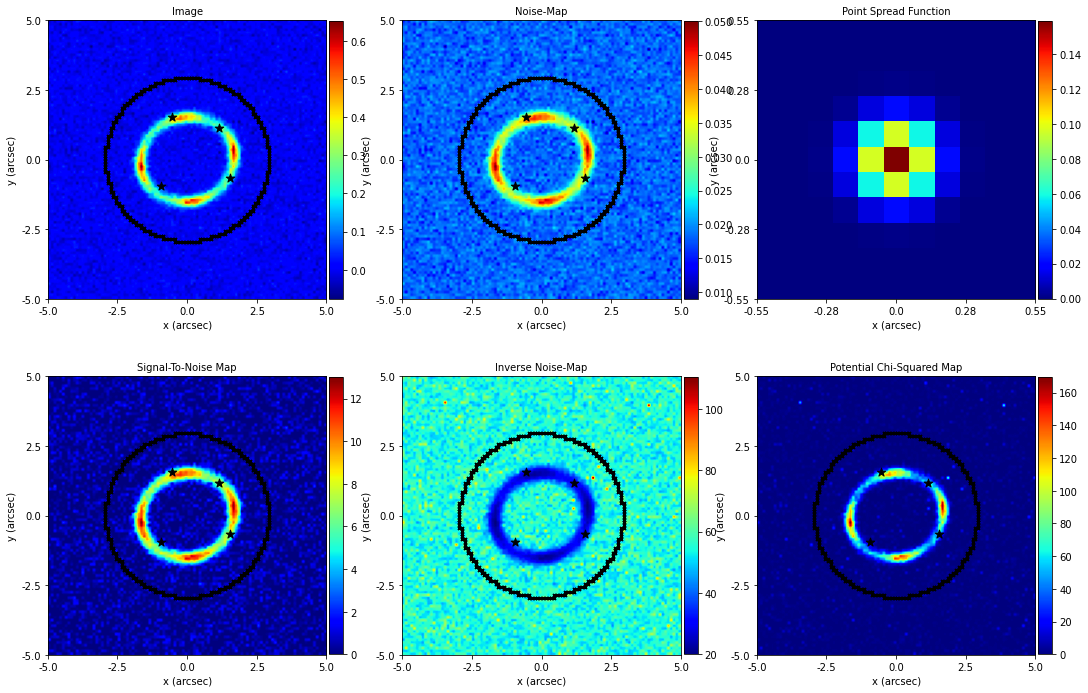

In [4]:
imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging.positions = al.Grid2DIrregular(
    [(1.55, -0.55), (1.15, 1.15), (-0.65, 1.55), (-0.95, -0.95)]
)

visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging.positions)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - An `EllipticalSersic` `LightProfile`.for the source galaxy's light (7 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

In [5]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. Below, we specify:

 - A positions_threshold of 0.5, meaning that the four (y,x) coordinates specified by our positions must trace
   within 0.5" of one another in the source-plane for a mass model to be accepted. If not, it is discarded and
   a new model is sampled.

The threshold of 0.5" is large. For an accurate lens model we would anticipate the positions trace within < 0.01" of
one another. However, we only want the threshold to aid the `NonLinearSearch` with the generation of the initial 
mass models. 

We do not want to risk inferring an incorrect mass model because our position threshold removed genuinely plausible 
solutions!

In [6]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)
settings_lens = al.SettingsLens(positions_threshold=0.5)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`, which we specify below. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that can be used with **PyAutoLens**. If you do not know what a `NonLinearSearch` is or how it 
operates, I recommend you complete chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/imaging/mass_sie__source_sersic/phase__positions`.

In [7]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "customize", dataset_name),
    name="phase_positions",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [8]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and mask to the phase, which will use the `NonLinearSearch` to fit
the model to the data. The dataset contains the positions, which is how they are input in the model-fit.

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase__mass_sie__source_bulge` to see how your fit is doing!

In [9]:
result = phase.run(dataset=imaging, mask=mask)

INFO:root:phase_positions already completed, skipping non-linear search.


__Wrap Up__

In this example, we used positional information about the lensed source galaxy's multiple images to speed up our
model-fit and make it more robust. 

PyAutoLens supports the following more advanced use of positional information:

 - If the unlensed source contains multiple components or clumps of light, one may wish to mark positions that 
      signify they correspond to these different regions of the source-plane. To do this, a list of list of tuples
      can be input into the Grid2DIrregular object, e.g:
      
      [[(1.0, 1.0), (0.5, 0.5)], [(-1.0, 1.0), (-0.5, 0.5)]]

      Note that in this example we only specified a single list of tuples, indicating all 4 positions were from the
      same region of the source.
      
      Before modeling a lens, it can be extremely difficult to be sure which parts of a lensed source eminate fom the
      same regons of the source-plane, and inputting positions as multiple lists is not advised. We would only advise
      this feature is used if one has spectroscopic information on the lensed source that makes it feasible to robustly
      identify which images correspond to the same regions of the source.
      
 - When using a single phase to fit a lens, we must manually specify or draw the positions on the lensed source and
      pass them to the phase. However, the `autolens_workspace/examples/chaining` scripts and PyAutoLens`s _Pipelines_
      feature break the model-fit into multiple _Phase`s_ which each perform a unique non-linear search.  
      
      If an intial phases successfully fits the lens's mass model, this model can be used to deterine the positions 
      and position threshold of the lensed source galaxy automatically. These can be then automatically set up as the
      positions and threshold used in the later phase`s, not requiring us to manually specifc the positions at all!
      
      To do this, we pass the `SettingsPhaseImaging` the input parameters `auto_positions_factor` and 
   `auto_positions_minumum_threshold`. An example of this can be found in the example script
   `autolens_workspace/notebooks/imaging/modeling/chaining/parametric_to_inversion.py`.